In [1]:
! apt-get update && apt-get install -y libsndfile1 ffmpeg
! pip -q install nemo_toolkit['asr'] Cython packaging

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1629 kB]
Get:6 https://packages.cloud.google.com/apt gcsfuse-focal InRelease [1225 B]
Get:7 https://packages.cloud.google.com/apt cloud-sdk InRelease [1616 B]
Get:8 https://packages.cloud.google.com/apt google-fast-socket InRelease [5015 B]
Hit:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Get:10 https://packages.cloud.google.com/apt gcsfuse-focal/main amd64 Packages [24.1 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [3877 kB]
Get:12 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [3071 kB]
Get:13 https://packages.cloud.google

In [2]:
import os
import zipfile
import json
import pandas as pd
import torchaudio
import librosa
import nemo
import torch
import nemo.collections.asr as nemo_asr
from nemo.collections.asr.models import EncDecCTCModel
from omegaconf import OmegaConf
from omegaconf import DictConfig
import torchaudio
from ruamel.yaml import YAML
from pytorch_lightning.utilities.model_summary import ModelSummary
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import Callback
import matplotlib.pyplot as plt

In [9]:
config = {
    "name": "QuartzNet15x5",
    "sample_rate": 16000,
    "repeat": 5,
    "dropout": 0.0,
    "separable": True,
    "labels": [' ', 'أ', 'ا', 'آ', 'إ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي', 'ى', 'ئ', 'ﻻ', 'ﻹ', 'ﻷ', 'ﻵ', 'ة', "ء", 'ؤ'],
    "model": {
        "train_ds": {
            "manifest_filepath": "/kaggle/input/full-manifest/full_manifest.json",  # Placeholder for manifest filepath
            "sample_rate": "${sample_rate}",
            "labels": "${labels}",
            "batch_size": 32,
            "trim_silence": True,
            "max_duration": 15,
            "shuffle": True,
            "num_workers": 8,
            "pin_memory": True,
            "is_tarred": False,
            "tarred_audio_filepaths": None,
            "shuffle_n": 2048,
            "bucketing_strategy": "synced_randomized",
            "bucketing_batch_size": None
        },
        "validation_ds": {
            "manifest_filepath": "/kaggle/input/train-on-kaggle/train_on_kaggle/adapt_manifest.json",  # Placeholder for manifest filepath
            "sample_rate": "${sample_rate}",
            "labels": "${labels}",
            "batch_size": 32,
            "shuffle": False,
            "num_workers": 8,
            "pin_memory": True
        },
        "preprocessor": {
            "_target_": "nemo.collections.asr.modules.AudioToMelSpectrogramPreprocessor",
            "normalize": "per_feature",
            "window_size": 0.02,
            "sample_rate": "${sample_rate}",
            "window_stride": 0.01,
            "window": "hann",
            "features": 64,
            "n_fft": 512,
            "frame_splicing": 1,
            "dither": 0.00001,
            "stft_conv": False
        },
        "spec_augment": {
            "_target_": "nemo.collections.asr.modules.SpectrogramAugmentation",
            "rect_freq": 50,
            "rect_masks": 5,
            "rect_time": 120
        },
        "encoder": {
            "_target_": "nemo.collections.asr.modules.ConvASREncoder",
            "feat_in": "${model.preprocessor.features}",
            "activation": "relu",
            "conv_mask": True,
            "jasper": [
                {
                    "dilation": [1],
                    "dropout": "${dropout}",
                    "filters": 256,
                    "kernel": [33],
                    "repeat": 1,
                    "residual": False,
                    "separable": "${separable}",
                    "stride": [2]
                },
                {
                    "dilation": [1],
                    "dropout": "${dropout}",
                    "filters": 256,
                    "kernel": [33],
                    "repeat": "${repeat}",
                    "residual": True,
                    "separable": "${separable}",
                    "stride": [1]
                },
                {
                    "dilation": [1],
                    "dropout": "${dropout}",
                    "filters": 256,
                    "kernel": [33],
                    "repeat": "${repeat}",
                    "residual": True,
                    "separable": "${separable}",
                    "stride": [1]
                },
                {
                    "dilation": [1],
                    "dropout": "${dropout}",
                    "filters": 256,
                    "kernel": [33],
                    "repeat": "${repeat}",
                    "residual": True,
                    "separable": "${separable}",
                    "stride": [1]
                },
                {
                    "dilation": [1],
                    "dropout": "${dropout}",
                    "filters": 256,
                    "kernel": [39],
                    "repeat": "${repeat}",
                    "residual": True,
                    "separable": "${separable}",
                    "stride": [1]
                },
                {
                    "dilation": [1],
                    "dropout": "${dropout}",
                    "filters": 256,
                    "kernel": [39],
                    "repeat": "${repeat}",
                    "residual": True,
                    "separable": "${separable}",
                    "stride": [1]
                },
                {
                    "dilation": [1],
                    "dropout": "${dropout}",
                    "filters": 256,
                    "kernel": [39],
                    "repeat": "${repeat}",
                    "residual": True,
                    "separable": "${separable}",
                    "stride": [1]
                },
                {
                    "dilation": [1],
                    "dropout": "${dropout}",
                    "filters": 512,
                    "kernel": [51],
                    "repeat": "${repeat}",
                    "residual": True,
                    "separable": "${separable}",
                    "stride": [1]
                },
                {
                    "dilation": [1],
                    "dropout": "${dropout}",
                    "filters": 512,
                    "kernel": [51],
                    "repeat": "${repeat}",
                    "residual": True,
                    "separable": "${separable}",
                    "stride": [1]
                },
                {
                    "dilation": [1],
                    "dropout": "${dropout}",
                    "filters": 512,
                    "kernel": [51],
                    "repeat": "${repeat}",
                    "residual": True,
                    "separable": "${separable}",
                    "stride": [1]
                },
                {
                    "dilation": [1],
                    "dropout": "${dropout}",
                    "filters": 512,
                    "kernel": [63],
                    "repeat": "${repeat}",
                    "residual": True,
                    "separable": "${separable}",
                    "stride": [1]
                },
                {
                    "dilation": [1],
                    "dropout": "${dropout}",
                    "filters": 512,
                    "kernel": [63],
                    "repeat": "${repeat}",
                    "residual": True,
                    "separable": "${separable}",
                    "stride": [1]
                },
                {
                    "dilation": [1],
                    "dropout": "${dropout}",
                    "filters": 512,
                    "kernel": [63],
                    "repeat": "${repeat}",
                    "residual": True,
                    "separable": "${separable}",
                    "stride": [1]
                },
                {
                    "dilation": [1],
                    "dropout": "${dropout}",
                    "filters": 512,
                    "kernel": [75],
                    "repeat": "${repeat}",
                    "residual": True,
                    "separable": "${separable}",
                    "stride": [1]
                },
                {
                    "dilation": [1],
                    "dropout": "${dropout}",
                    "filters": 512,
                    "kernel": [75],
                    "repeat": "${repeat}",
                    "residual": True,
                    "separable": "${separable}",
                    "stride": [1]
                },
                {
                    "dilation": [1],
                    "dropout": "${dropout}",
                    "filters": 512,
                    "kernel": [75],
                    "repeat": "${repeat}",
                    "residual": True,
                    "separable": "${separable}",
                    "stride": [1]
                },
                {
                    "dilation": [2],
                    "dropout": "${dropout}",
                    "filters": 512,
                    "kernel": [87],
                    "repeat": 1,
                    "residual": False,
                    "separable": "${separable}",
                    "stride": [1]
                },
                {
                    "dilation": [1],
                    "dropout": "${dropout}",
                    "filters": 1024,
                    "kernel": [1],
                    "repeat": 1,
                    "residual": False,
                    "stride": [1]
                }
            ]
        },
        "decoder": {
            "_target_": "nemo.collections.asr.modules.ConvASRDecoder",
            "feat_in": 1024,
            "num_classes": 41,
            "vocabulary": "${labels}"
        },
        "optim": {
            "name": "novograd",
            "lr": 0.01,
            "betas": [0.8, 0.5],
            "weight_decay": 0.001,
            "sched": {
                "name": "CosineAnnealing",
                "monitor": "val_loss",
                "reduce_on_plateau": False,
                "warmup_steps": None,
                "warmup_ratio": None,
                "min_lr": 0.0,
                "last_epoch": -1
            }
        }
    },
    "exp_manager": {
        "exp_dir": None,
        "name": "${name}",
        
        "create_tensorboard_logger": True,
        "create_checkpoint_callback": True,
        "checkpoint_callback_params": {
            "monitor": "val_wer",
            "mode": "min"
        },
        "create_wandb_logger": False,
        "wandb_logger_kwargs": {
            "name": None,
            "project": None
        }
    }
}

# Create an OmegaConf object from the dictionary
conf = OmegaConf.create(config)

In [10]:
# Create a TensorBoard logger
logger = TensorBoardLogger("logs", name="QuartzNet15x5")

In [11]:
class LossLogger(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        self.train_wer = []
        self.val_wer = []

    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get('train_loss')
        train_wer = trainer.callback_metrics.get('train_wer')
        
        if train_loss is not None:
            self.train_losses.append(train_loss.item())
            print(f".. Train Loss: {train_loss.item()} ..")
        
        if train_wer is not None:
            self.train_wer.append(train_wer.item())
            print(f".. Train WER: {train_wer.item()} ..")

    def on_validation_epoch_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics.get('val_loss')
        val_wer = trainer.callback_metrics.get('val_wer')
        
        if val_loss is not None:
            self.val_losses.append(val_loss.item())
            print(f".. Validation Loss: {val_loss.item()} ..")
        if val_wer is not None:
            self.val_wer.append(val_wer.item())
            print(f".. Validation WER: {val_wer.item()} ..\n *********** \n")
            

    def on_train_end(self, trainer, pl_module):
        
        plt.figure(figsize=(10, 6))
        plt.subplot(2, 1, 1)
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')

        plt.subplot(2, 1, 2)
        plt.plot(self.train_wer, label='Training WER')
        plt.plot(self.val_wer, label='Validation WER')
        plt.xlabel('Epoch')
        plt.ylabel('WER')
        plt.legend()
        plt.title('Training and Validation WER')

        plt.tight_layout()
        plt.show()

loss_logger = LossLogger()

In [12]:
trainer = pl.Trainer(
    precision='16-mixed',
    devices=1,
    num_nodes=1,
    accelerator='gpu',
    
    max_epochs=20,
    accumulate_grad_batches=1,
    log_every_n_steps=150, 
    logger=logger,            # Logger object for logging training progress. Here, we use TensorBoardLogger.
    val_check_interval=1.0,      # How often within one training epoch to check validation set. Here, it's checked once per epoch.
    benchmark=True,            # If True, enables cudnn benchmarking for faster training. 
    callbacks=[loss_logger]
)

In [13]:
quartznet = nemo_asr.models.EncDecCTCModel(cfg=conf['model'], trainer=trainer)

[NeMo I 2024-07-01 12:45:53 audio_to_text_dataset:49] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2024-07-01 12:45:53 audio_to_text_dataset:49] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2024-07-01 12:45:56 collections:196] Dataset loaded with 52777 files totalling 99.69 hours
[NeMo I 2024-07-01 12:45:56 collections:197] 131 files were filtered totalling 0.73 hours


[NeMo W 2024-07-01 12:45:56 nemo_logging:349] /opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      warnings.warn(_create_warning_msg(
    


[NeMo I 2024-07-01 12:45:56 audio_to_text_dataset:49] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2024-07-01 12:45:56 audio_to_text_dataset:49] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2024-07-01 12:45:56 collections:196] Dataset loaded with 2199 files totalling 2.99 hours
[NeMo I 2024-07-01 12:45:56 collections:197] 0 files were filtered totalling 0.00 hours
[NeMo I 2024-07-01 12:45:56 features:289] PADDING: 16


In [14]:
summary = ModelSummary(quartznet)
print(summary)

  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 18.9 M
2 | decoder           | ConvASRDecoder                    | 43.1 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | wer               | WER                               | 0     
------------------------------------------------------------------------
18.9 M    Trainable params
0         Non-trainable params
18.9 M    Total params
75.751    Total estimated model params size (MB)


2024-07-01 12:45:59.429161: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 12:45:59.429297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 12:45:59.560859: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[NeMo I 2024-07-01 12:46:08 modelPT:723] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0.001
    )
[NeMo I 2024-07-01 12:46:08 lr_scheduler:915] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7b54242ca140>" 
    will be used during training (effective maximum steps = 33000) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 33000
    )


Sanity Checking: 0it [00:00, ?it/s]

[NeMo W 2024-07-01 12:46:09 nemo_logging:349] /opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
      self.pid = os.fork()
    


Training: 0it [00:00, ?it/s]

[NeMo W 2024-07-01 12:47:07 nemo_logging:349] /opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
      warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
    


Validation: 0it [00:00, ?it/s]

.. Train Loss: 184.01739501953125 ..


Validation: 0it [00:00, ?it/s]

.. Validation Loss: 149.0666046142578 ..
.. Validation WER: 1.0 ..
 *********** 

.. Train Loss: 187.63406372070312 ..


Validation: 0it [00:00, ?it/s]

.. Validation Loss: nan ..
.. Validation WER: 1.0 ..
 *********** 

.. Train Loss: 210.7601776123047 ..


Validation: 0it [00:00, ?it/s]

.. Validation Loss: nan ..
.. Validation WER: 1.000284194946289 ..
 *********** 

.. Train Loss: 181.27670288085938 ..


Validation: 0it [00:00, ?it/s]

.. Validation Loss: nan ..
.. Validation WER: 0.996684193611145 ..
 *********** 

.. Train Loss: 153.9208526611328 ..


Validation: 0it [00:00, ?it/s]

.. Validation Loss: nan ..
.. Validation WER: 0.9877315163612366 ..
 *********** 

.. Train Loss: 115.99906158447266 ..


Validation: 0it [00:00, ?it/s]

.. Validation Loss: nan ..
.. Validation WER: 0.987589418888092 ..
 *********** 

.. Train Loss: 148.93414306640625 ..


Validation: 0it [00:00, ?it/s]

.. Validation Loss: nan ..
.. Validation WER: 0.9767893552780151 ..
 *********** 

.. Train Loss: 94.97279357910156 ..


Validation: 0it [00:00, ?it/s]

.. Validation Loss: 89.4779052734375 ..
.. Validation WER: 0.9514471292495728 ..
 *********** 

.. Train Loss: 113.405517578125 ..


Validation: 0it [00:00, ?it/s]

.. Validation Loss: nan ..
.. Validation WER: 0.9396049380302429 ..
 *********** 

.. Train Loss: 75.5792236328125 ..


Validation: 0it [00:00, ?it/s]

.. Validation Loss: 80.98410034179688 ..
.. Validation WER: 0.917436420917511 ..
 *********** 

.. Train Loss: 96.36200714111328 ..


Validation: 0it [00:00, ?it/s]

.. Validation Loss: 75.91498565673828 ..
.. Validation WER: 0.8955994248390198 ..
 *********** 

.. Train Loss: 84.16138458251953 ..


Validation: 0it [00:00, ?it/s]

.. Validation Loss: 73.21237182617188 ..
.. Validation WER: 0.8794467449188232 ..
 *********** 

.. Train Loss: 89.33782196044922 ..


Validation: 0it [00:00, ?it/s]

.. Validation Loss: nan ..
.. Validation WER: 0.8837099075317383 ..
 *********** 

.. Train Loss: 99.70793151855469 ..


Validation: 0it [00:00, ?it/s]

.. Validation Loss: nan ..
.. Validation WER: 0.8405570387840271 ..
 *********** 

.. Train Loss: 78.1988525390625 ..


Validation: 0it [00:00, ?it/s]

.. Validation Loss: nan ..
.. Validation WER: 0.8430202007293701 ..
 *********** 

.. Train Loss: 71.15916442871094 ..


Validation: 0it [00:00, ?it/s]

.. Validation Loss: nan ..
.. Validation WER: 0.8284780383110046 ..
 *********** 

.. Train Loss: 98.8260498046875 ..


Validation: 0it [00:00, ?it/s]

.. Validation Loss: nan ..
.. Validation WER: 0.8142200708389282 ..
 *********** 

.. Train Loss: 84.94231414794922 ..


Validation: 0it [00:00, ?it/s]

.. Validation Loss: nan ..
.. Validation WER: 0.8121358752250671 ..
 *********** 

.. Train Loss: 93.96041870117188 ..


Validation: 0it [00:00, ?it/s]

.. Validation Loss: nan ..
.. Validation WER: 0.8101937174797058 ..
 *********** 

.. Train Loss: 69.65518951416016 ..


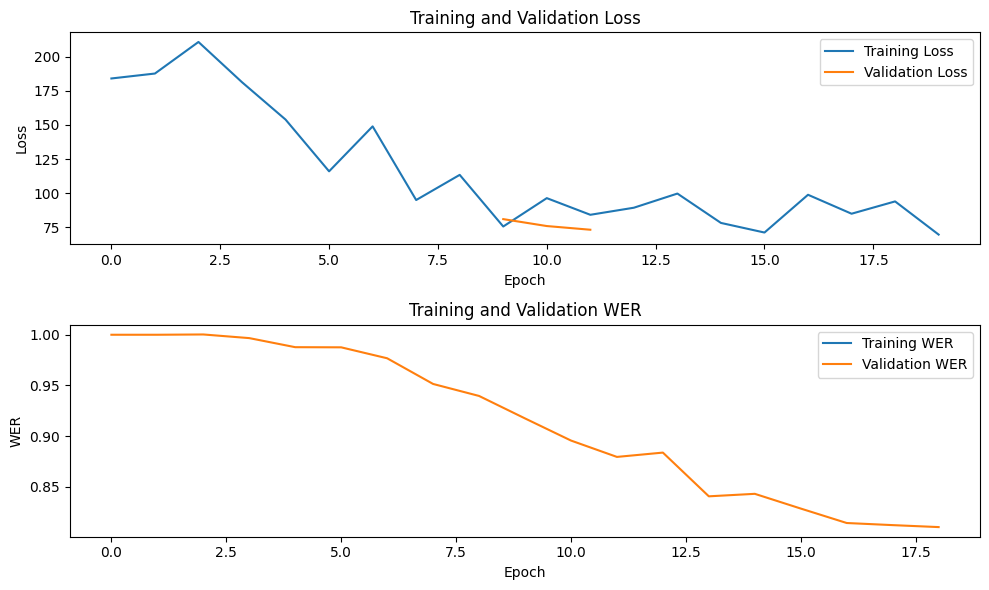

In [15]:
# Start training !!!
trainer.fit(quartznet)

In [16]:
output_dir = '/kaggle/working'
model_save_path = f'{output_dir}/quartznet_full_20_epochs.nemo'


quartznet.save_to(model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to /kaggle/working/quartznet_full_20_epochs.nemo


In [18]:
def zip_folder(folder_path, output_path):
    # Create a ZipFile object
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Walk through the folder
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                # Create the full path to the file
                file_path = os.path.join(root, file)
                # Add the file to the zip file
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

# Define the folder to be zipped and the output path
folder_to_zip = "/kaggle/working/logs"
output_zip_path = "/kaggle/working/logs.zip"

# Call the function to zip the folder
zip_folder(folder_to_zip, output_zip_path)